In [1]:
import os
import platform
import time
import itertools
import glob as glob 

import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, average_precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator
from scipy.stats import uniform, loguniform, randint
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [2]:
DATA_DIR = 'dataset_full'
CSV_PATH = 'dataset_full/labels_updated.csv' 

DATA_DIR_SMALL = 'testing'
CSV_PATH_SMALL = 'testing/labels_updated.csv'


EXPERIMENT_PATH = 'real'

BATCH_SIZE = 48
EPOCHS = 20
LEARNING_RATE = 15e-4

IMAGE_SIZE = (256, 256)
CHANNELS = 3
INPUT_SHAPE = IMAGE_SIZE + (CHANNELS,)


In [3]:
df = pd.read_csv(CSV_PATH)
df

df_small = pd.read_csv(CSV_PATH_SMALL)

In [4]:
train_df = df[df['split'] == 'train']  # Filter for train split
val_df = df[df['split'] == 'valid']   # Filter for valid split
test_df = df[df['split'] == 'test']

print(f'Number of total images:\ntrain={len(train_df)}, val={len(val_df)}, test={len(test_df)}')

Number of total images:
train=35348, val=4418, test=4419


In [5]:
train_df_small = df_small[df_small['split'] == 'train']  # Filter for train split
val_df_small = df_small[df_small['split'] == 'valid']   # Filter for valid split
test_df_small = df_small[df_small['split'] == 'test']

print(f'Number of total images (small datasaet):\ntrain={len(train_df_small)}, val={len(val_df_small)}, test={len(test_df_small)}')

Number of total images (small datasaet):
train=14139, val=1767, test=1768


In [7]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

class CXRDataset(Dataset):
    def __init__(self, dataframe, size='big',transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        if self.size == 'big':
            path=os.path.join(DATA_DIR,row['split'],row['image_name'])
        elif self.size == 'small':
            path=os.path.join(DATA_DIR_SMALL,row['split'],row['image_name'])

        img = Image.open(path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        labels = torch.tensor([
            row['Atelectasis'],
            row['Cardiomegaly'],
            row['Consolidation'],
            row['Edema'],
            row['Enlarged Cardiomediastinum'],
            row['Fracture'],
            row['Lung Lesion'],
            row['Lung Opacity'],
            row['No Finding'],
            row['Pleural Effusion'],
            row['Pneumonia'],
            row['Pneumothorax'],
        ], dtype=torch.float32)

        return img, labels


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])



train_dataset = CXRDataset(train_df, transform=train_transform)
val_dataset   = CXRDataset(val_df, transform=eval_transform)
test_dataset  = CXRDataset(test_df, transform=eval_transform)


train_dataset_small = CXRDataset(train_df_small,transform=train_transform, size='small')
val_dataset_small = CXRDataset(val_df_small,transform=eval_transform, size='small')

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
import torch.optim.rmsprop


param_grid = {
    'learning_rate': [1e-5, 5e-5, 15e-4, 1e-4, 5e-4, 1e-3, 5e-3],  
    'batch_size': [16, 32, 48, 64],
    'optimizer': ['adam', 'adamw', 'rmsprop'],
    'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  
    'weight_decay': [0.0, 1e-6, 1e-5,1e-4]  
}

def calculate_auc(outputs, targets):
    """Calculate AUC for each label and return the mean AUC"""
    outputs_np = outputs.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()

    auc_scores = []
    for i in range(targets_np.shape[1]):
        try:
            # Skip if all values are the same (cannot calculate AUC)
            if len(np.unique(targets_np[:, i])) > 1:
                auc = roc_auc_score(targets_np[:, i], outputs_np[:, i])
                auc_scores.append(auc)
        except ValueError:
            continue

    if auc_scores:
        return np.mean(auc_scores)
    else:
        return 0.0
    
class PyTorchClassifier(BaseEstimator):
    def __init__(self, model_name='densenet121', learning_rate=1e-4, batch_size=48,
                 optimizer='adam', dropout=0.0, weight_decay=0.0, epochs=3):
        self.model_name = model_name
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.dropout = dropout
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def _create_model(self):
        num_labels = 12

        if self.model_name == 'alexnet':
            model = models.alexnet(weights='IMAGENET1K_V1')
            # Modify the classifier
            model.classifier = nn.Sequential(
                nn.Dropout(self.dropout),
                nn.Linear(model.classifier[1].in_features, num_labels),
                nn.Sigmoid()
            )

        elif self.model_name == 'densenet121':
            model = models.densenet121(weights='IMAGENET1K_V1')
            # Modify the classifier
            model.classifier = nn.Sequential(
                nn.Dropout(self.dropout),
                nn.Linear(model.classifier.in_features, num_labels),
                nn.Sigmoid()
            )

        elif self.model_name == 'resnet101':
            model = models.resnet101(weights='IMAGENET1K_V1')
            # Modify the fully connected layer
            model.fc = nn.Sequential(
                nn.Dropout(self.dropout),
                nn.Linear(model.fc.in_features, num_labels),
                nn.Sigmoid()
            )

        elif self.model_name == 'vit_b_16':
            model = models.vit_b_16(weights='IMAGENET1K_V1')
            # Modify the head
            model.heads = nn.Sequential(
                nn.Dropout(self.dropout),
                nn.Linear(model.heads.head.in_features, num_labels),
                nn.Sigmoid()
            )

        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

        return model.to(self.device)

    def _create_optimizer(self, model):
        if self.optimizer == 'adam':
            return torch.optim.Adam(model.parameters(), lr=self.learning_rate,
                                  weight_decay=self.weight_decay)
        elif self.optimizer == 'adamw':
            return torch.optim.AdamW(model.parameters(), lr=self.learning_rate,
                                   weight_decay=self.weight_decay)
        elif self.optimizer == 'rmsprop':
            return torch.optim.RMSprop(model.parameters(), lr=self.learning_rate,
                                weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

    def fit(self, X, y):
        model = self._create_model()
        criterion = nn.BCELoss()
        optimizer = self._create_optimizer(model)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                             factor=0.5, patience=3,
                                                             verbose=False)

        # Create data loaders with current batch size
        train_loader = DataLoader(train_dataset_small, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset_small, batch_size=self.batch_size, shuffle=False)

        best_val_auc = 0

        for epoch in range(self.epochs):
            model.train()
            train_loss = 0.0
            train_outputs_list = []
            train_targets_list = []

            for images, labels in train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_outputs_list.append(outputs.detach().cpu())
                train_targets_list.append(labels.detach().cpu())

            # Calculate training AUC
            train_outputs_all = torch.cat(train_outputs_list, dim=0)
            train_targets_all = torch.cat(train_targets_list, dim=0)
            train_auc = calculate_auc(train_outputs_all, train_targets_all)

            # Validate
            val_loss, val_auc = self._evaluate(model, val_loader, criterion)

            # Adjust learning rate
            scheduler.step(val_loss)

            # Save best model
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                self.best_model_state = model.state_dict()

        self.best_val_auc = best_val_auc
        return self

    def _evaluate(self, model, dataloader, criterion):
        model.eval()
        total_loss = 0.0
        outputs_list = []
        targets_list = []

        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                total_loss += loss.item()

                outputs_list.append(outputs.cpu())
                targets_list.append(labels.cpu())

        outputs_all = torch.cat(outputs_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
        auc = calculate_auc(outputs_all, targets_all)

        return total_loss / len(dataloader), auc

    def score(self, X, y=None):
        # Return the best validation AUC
        return self.best_val_auc



In [10]:
class PyTorchClassifier(BaseEstimator):
    def __init__(self, model_name='densenet121', learning_rate=1e-4, batch_size=48,
                 optimizer='adam', dropout=0.0, weight_decay=0.0, epochs=3):
        self.model_name = model_name
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.dropout = dropout
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.best_model_state = None
        self.best_val_auc = 0

    def _create_model(self):
        num_labels = 12

        if self.model_name == 'alexnet':
            model = models.alexnet(weights='IMAGENET1K_V1')
            model.classifier = nn.Sequential(
                nn.Dropout(self.dropout),
                nn.Linear(model.classifier[1].in_features, num_labels),
                nn.Sigmoid()
            )

        elif self.model_name == 'densenet121':
            model = models.densenet121(weights='IMAGENET1K_V1')
            model.classifier = nn.Sequential(
                nn.Dropout(self.dropout),
                nn.Linear(model.classifier.in_features, num_labels),
                nn.Sigmoid()
            )

        elif self.model_name == 'resnet101':
            model = models.resnet101(weights='IMAGENET1K_V1')
            model.fc = nn.Sequential(
                nn.Dropout(self.dropout),
                nn.Linear(model.fc.in_features, num_labels),
                nn.Sigmoid()
            )

        elif self.model_name == 'vit_b_16':
            model = models.vit_b_16(weights='IMAGENET1K_V1')
            model.heads = nn.Sequential(
                nn.Dropout(self.dropout),
                nn.Linear(model.heads.head.in_features, num_labels),
                nn.Sigmoid()
            )

        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

        return model.to(self.device)

    def _create_optimizer(self, model):
        if self.optimizer == 'adam':
            return torch.optim.Adam(model.parameters(), lr=self.learning_rate,
                                  weight_decay=self.weight_decay)
        elif self.optimizer == 'adamw':
            return torch.optim.AdamW(model.parameters(), lr=self.learning_rate,
                                   weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

    def fit(self, X, y):
        model = self._create_model()
        criterion = nn.BCELoss()
        optimizer = self._create_optimizer(model)

        # Create data loaders with current batch size
        train_loader = DataLoader(train_dataset_small, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset_small, batch_size=self.batch_size, shuffle=False)

        best_val_auc = 0
        patience = 2
        patience_counter = 0

        for epoch in range(self.epochs):
            model.train()
            train_loss = 0.0
            train_outputs_list = []
            train_targets_list = []

            for images, labels in train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_outputs_list.append(outputs.detach().cpu())
                train_targets_list.append(labels.detach().cpu())

            # Calculate training AUC
            train_outputs_all = torch.cat(train_outputs_list, dim=0)
            train_targets_all = torch.cat(train_targets_list, dim=0)
            train_auc = calculate_auc(train_outputs_all, train_targets_all)

            # Validate
            val_loss, val_auc = self._evaluate(model, val_loader, criterion)

            # Early stopping
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                self.best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        self.best_val_auc = best_val_auc
        return self

    def _evaluate(self, model, dataloader, criterion):
        model.eval()
        total_loss = 0.0
        outputs_list = []
        targets_list = []

        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                total_loss += loss.item()

                outputs_list.append(outputs.cpu())
                targets_list.append(labels.cpu())

        outputs_all = torch.cat(outputs_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
        auc = calculate_auc(outputs_all, targets_all)

        return total_loss / len(dataloader), auc

    def predict_proba(self, X):
        """
        Return probability estimates for the test data X.
        This method is required by scikit-learn's roc_auc scorer.
        """
        # Load the best model
        model = self._create_model()
        model.load_state_dict(self.best_model_state)
        model.eval()

        # Create a dataloader for the validation set
        val_loader = DataLoader(val_dataset_small, batch_size=self.batch_size, shuffle=False)

        outputs_list = []
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(self.device)
                outputs = model(images)
                outputs_list.append(outputs.cpu())

        outputs_all = torch.cat(outputs_list, dim=0)
        return outputs_all.numpy()

    def score(self, X, y=None):
        return self.best_val_auc

# Create a custom scorer that uses the validation AUC directly
def custom_scorer(estimator, X, y):
    return estimator.best_val_auc

In [ ]:
model_alex = PyTorchClassifier(model_name='alexnet')

random_search = RandomizedSearchCV(
    estimator=model_alex,
    param_distributions=param_grid,
    n_iter=10,  
    cv=None,  
    scoring=custom_scorer,  
    n_jobs=1, 
    verbose=10,
    random_state=42
)

# Fit the random search

X_dummy = np.zeros((len(train_df_small), 1))
y_dummy = np.zeros((len(train_df_small), 1))

random_search.fit(X_dummy, y_dummy)

# Print the best parametersw
print("Best parameters found:")
print(random_search.best_params_)
print(f"Best validation AUC: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06
[CV 1/5; 1/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.655 total time= 2.6min
[CV 2/5; 1/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06
[CV 2/5; 1/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.668 total time= 2.6min
[CV 3/5; 1/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06
[CV 3/5; 1/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.666 total time= 2.7min
[CV 4/5; 1/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06
[CV 4/5; 1/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;

c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\w2\AppData\Local\Temp\ipykernel_54096\3762132310.py", line 68, in fit
    optimizer = self._create_optimizer(model)
  File "C:\Users\w2\AppData\Local\Temp\ipykernel_54096\3762132310.py", line 63, in _create_optimizer
    raise ValueError(f"U

Best parameters found:
{'weight_decay': 1e-06, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.1, 'batch_size': 32}
Best validation AUC: 0.6703


In [30]:
model_dense = PyTorchClassifier(model_name='densenet121')

random_search = RandomizedSearchCV(
    estimator=model_dense,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    cv=2,  
    scoring=custom_scorer,  # Use AUC as the scoring metric
    n_jobs=1,  # Set to 1 for GPU training
    verbose=10,
    random_state=42
)

# Fit the random search
# Note: X and y are dummy variables, we use the global datasets
X_dummy = np.zeros((len(train_df_small), 1))
y_dummy = np.zeros((len(train_df_small), 1))

random_search.fit(X_dummy, y_dummy)

# Print the best parametersw
print("Best parameters found:")
print(random_search.best_params_)
print(f"Best validation AUC: {random_search.best_score_:.4f}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 1/10] END batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.610 total time= 4.6min
[CV 2/2; 1/10] START batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 1/10] END batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.596 total time= 3.4min
[CV 1/2; 2/10] START batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 2/10] END batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001;, score=0.641 total time= 3.4min
[CV 2/2; 2/10] START batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 2/10] END batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001;, score=0.619 total time= 3.4min
[CV 1/2; 3/10] START batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 3/10] END batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0;, score=0.687 total time= 4.2min
[CV 2/2; 3/10] START batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 3/10] END batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0;, score=0.705 total time= 3.6min
[CV 1/2; 4/10] START batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 4/10] END batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.617 total time= 3.3min
[CV 2/2; 4/10] START batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 4/10] END batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.614 total time= 3.4min
[CV 1/2; 5/10] START batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 5/10] END batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05;, score=0.703 total time= 3.3min
[CV 2/2; 5/10] START batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 5/10] END batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05;, score=0.709 total time= 3.3min
[CV 1/2; 6/10] START batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 6/10] END batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001;, score=0.652 total time= 3.3min
[CV 2/2; 6/10] START batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 6/10] END batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001;, score=0.654 total time= 3.3min
[CV 1/2; 7/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 7/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0;, score=0.704 total time= 3.3min
[CV 2/2; 7/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 7/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0;, score=0.713 total time= 3.3min
[CV 1/2; 8/10] START batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 8/10] END batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0;, score=0.705 total time= 3.3min
[CV 2/2; 8/10] START batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 8/10] END batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0;, score=0.717 total time= 3.3min
[CV 1/2; 9/10] START batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 9/10] END batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05;, score=0.709 total time= 3.3min
[CV 2/2; 9/10] START batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 9/10] END batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05;, score=0.709 total time= 3.3min
[CV 1/2; 10/10] START batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 10/10] END batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.714 total time= 3.5min
[CV 2/2; 10/10] START batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 10/10] END batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.713 total time= 3.5min


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Best parameters found:
{'weight_decay': 1e-06, 'optimizer': 'adam', 'learning_rate': 0.0001, 'dropout': 0.1, 'batch_size': 16}
Best validation AUC: 0.7136


In [ ]:
model_dense = PyTorchClassifier(model_name='densenet121')

random_search = RandomizedSearchCV(
    estimator=model_dense,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    cv=2,  
    scoring=custom_scorer,  # Use AUC as the scoring metric
    n_jobs=1,  # Set to 1 for GPU training
    verbose=10,
    random_state=42
)

# Fit the random search
# Note: X and y are dummy variables, we use the global datasets
X_dummy = np.zeros((len(train_df_small), 1))
y_dummy = np.zeros((len(train_df_small), 1))

random_search.fit(X_dummy, y_dummy)

# Print the best parametersw
print("Best parameters found:")
print(random_search.best_params_)
print(f"Best validation AUC: {random_search.best_score_:.4f}")

In [32]:
model_resnet = PyTorchClassifier(model_name='resnet101')

random_search = RandomizedSearchCV(
    estimator=model_resnet,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    cv=2,  
    scoring=custom_scorer,  # Use AUC as the scoring metric
    n_jobs=1,  # Set to 1 for GPU training
    verbose=10,
    random_state=42
)

# Fit the random search
# Note: X and y are dummy variables, we use the global datasets
X_dummy = np.zeros((len(train_df_small), 1))
y_dummy = np.zeros((len(train_df_small), 1))

random_search.fit(X_dummy, y_dummy)

# Print the best parametersw
print("Best parameters found:")
print(random_search.best_params_)
print(f"Best validation AUC: {random_search.best_score_:.4f}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 1/10] END batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.603 total time= 3.8min
[CV 2/2; 1/10] START batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 1/10] END batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.605 total time= 3.8min
[CV 1/2; 2/10] START batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 2/10] END batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001;, score=0.629 total time= 3.8min
[CV 2/2; 2/10] START batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 2/10] END batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001;, score=0.623 total time= 3.7min
[CV 1/2; 3/10] START batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 3/10] END batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0;, score=0.713 total time= 3.7min
[CV 2/2; 3/10] START batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 3/10] END batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0;, score=0.710 total time= 3.7min
[CV 1/2; 4/10] START batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 4/10] END batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.603 total time= 3.7min
[CV 2/2; 4/10] START batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 4/10] END batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.624 total time= 3.7min
[CV 1/2; 5/10] START batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 5/10] END batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05;, score=0.711 total time= 3.7min
[CV 2/2; 5/10] START batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 5/10] END batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05;, score=0.708 total time= 3.7min
[CV 1/2; 6/10] START batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 6/10] END batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001;, score=0.688 total time= 3.7min
[CV 2/2; 6/10] START batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 6/10] END batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001;, score=0.689 total time= 3.7min
[CV 1/2; 7/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 7/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0;, score=0.709 total time= 3.7min
[CV 2/2; 7/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 7/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0;, score=0.719 total time= 3.7min
[CV 1/2; 8/10] START batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 8/10] END batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0;, score=0.717 total time= 3.7min
[CV 2/2; 8/10] START batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 8/10] END batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0;, score=0.697 total time= 3.7min
[CV 1/2; 9/10] START batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 9/10] END batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05;, score=0.712 total time= 3.7min
[CV 2/2; 9/10] START batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 9/10] END batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05;, score=0.709 total time= 3.7min
[CV 1/2; 10/10] START batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 10/10] END batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.705 total time= 3.7min
[CV 2/2; 10/10] START batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 10/10] END batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.706 total time= 3.8min


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Best parameters found:
{'weight_decay': 0.0, 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'dropout': 0.2, 'batch_size': 64}
Best validation AUC: 0.7142


In [33]:
model_vit = PyTorchClassifier(model_name='vit_b_16')

random_search = RandomizedSearchCV(
    estimator=model_vit,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    cv=2,  
    scoring=custom_scorer,  # Use AUC as the scoring metric
    n_jobs=1,  # Set to 1 for GPU training
    verbose=10,
    random_state=42
)

# Fit the random search
# Note: X and y are dummy variables, we use the global datasets
X_dummy = np.zeros((len(train_df_small), 1))
y_dummy = np.zeros((len(train_df_small), 1))

random_search.fit(X_dummy, y_dummy)

# Print the best parametersw
print("Best parameters found:")
print(random_search.best_params_)
print(f"Best validation AUC: {random_search.best_score_:.4f}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\w2/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:14<00:00, 23.8MB/s] 
c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 1/10] END batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.511 total time= 5.3min
[CV 2/2; 1/10] START batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 1/10] END batch_size=48, dropout=0.1, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.506 total time= 5.1min
[CV 1/2; 2/10] START batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 2/10] END batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001;, score=0.540 total time= 5.1min
[CV 2/2; 2/10] START batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 2/10] END batch_size=48, dropout=0.5, learning_rate=0.0015, optimizer=adamw, weight_decay=0.0001;, score=0.548 total time= 5.1min
[CV 1/2; 3/10] START batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 3/10] END batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0;, score=0.644 total time= 5.1min
[CV 2/2; 3/10] START batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 3/10] END batch_size=32, dropout=0.4, learning_rate=5e-05, optimizer=rmsprop, weight_decay=0.0;, score=0.694 total time= 5.1min
[CV 1/2; 4/10] START batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 4/10] END batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.495 total time= 5.1min
[CV 2/2; 4/10] START batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 4/10] END batch_size=48, dropout=0.3, learning_rate=0.0015, optimizer=rmsprop, weight_decay=1e-05;, score=0.506 total time= 5.1min
[CV 1/2; 5/10] START batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 5/10] END batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05;, score=0.690 total time= 5.1min
[CV 2/2; 5/10] START batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 5/10] END batch_size=48, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-05;, score=0.682 total time= 5.1min
[CV 1/2; 6/10] START batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 6/10] END batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001;, score=0.696 total time= 5.1min
[CV 2/2; 6/10] START batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 6/10] END batch_size=48, dropout=0.1, learning_rate=1e-05, optimizer=adam, weight_decay=0.0001;, score=0.693 total time= 5.0min
[CV 1/2; 7/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 7/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0;, score=0.558 total time= 4.9min
[CV 2/2; 7/10] START batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 7/10] END batch_size=64, dropout=0.2, learning_rate=0.0001, optimizer=rmsprop, weight_decay=0.0;, score=0.554 total time= 4.9min
[CV 1/2; 8/10] START batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 8/10] END batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0;, score=0.692 total time= 4.9min
[CV 2/2; 8/10] START batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 8/10] END batch_size=48, dropout=0.0, learning_rate=0.0001, optimizer=adam, weight_decay=0.0;, score=0.686 total time= 4.9min
[CV 1/2; 9/10] START batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 9/10] END batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05;, score=0.694 total time= 4.9min
[CV 2/2; 9/10] START batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 9/10] END batch_size=64, dropout=0.1, learning_rate=0.0001, optimizer=adamw, weight_decay=1e-05;, score=0.695 total time= 4.9min
[CV 1/2; 10/10] START batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 1/2; 10/10] END batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.638 total time= 5.3min
[CV 2/2; 10/10] START batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[CV 2/2; 10/10] END batch_size=16, dropout=0.1, learning_rate=0.0001, optimizer=adam, weight_decay=1e-06;, score=0.671 total time= 5.3min


c:\Users\w2\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Best parameters found:
{'weight_decay': 0.0001, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.1, 'batch_size': 48}
Best validation AUC: 0.6946


#AlexNet


In [12]:
#{'weight_decay': 1e-06, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.1, 'batch_size': 32}

import torch
import torch.nn as nn
import torchvision.models as models

alexnet = models.alexnet(weights='IMAGENET1K_V1')

#for param in densenet.parameters():
  #  param.requires_grad = False

num_labels = 12
alexnet.classifier = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(alexnet.classifier[1].in_features, num_labels),
                nn.Sigmoid()
            )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(alexnet.parameters(), lr=5e-5, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

history_alexnet ={'training_loss':[],
     'validation_loss': []}

from sklearn.metrics import roc_auc_score

def calculate_auc(outputs, targets):
    """Calculate AUC for each label and return the mean AUC"""
    outputs_np = outputs.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()

    auc_scores = []
    for i in range(targets_np.shape[1]):
        try:
            # Skip if all values are the same (cannot calculate AUC)
            if len(np.unique(targets_np[:, i])) > 1:
                auc = roc_auc_score(targets_np[:, i], outputs_np[:, i])
                auc_scores.append(auc)
        except ValueError:
            continue

    if auc_scores:
        return np.mean(auc_scores)
    else:
        return 0.0

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20):
    best_val_auc = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_outputs_list = []
        train_targets_list = []

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        loop = tqdm(train_loader, desc='Training', leave=False)

        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store outputs and targets for AUC calculation
            train_outputs_list.append(outputs.detach().cpu())
            train_targets_list.append(labels.detach().cpu())

            loop.set_postfix(loss=loss.item())

        # Calculate training AUC
        train_outputs_all = torch.cat(train_outputs_list, dim=0)
        train_targets_all = torch.cat(train_targets_list, dim=0)
        train_auc = calculate_auc(train_outputs_all, train_targets_all)

        avg_train_loss = train_loss / len(train_loader)
        print(f"Train Loss: {avg_train_loss:.4f} | AUC: {train_auc:.4f}")

        # Validate
        val_loss, val_auc = evaluate(model, val_loader, criterion, device)
        print(f"Val Loss:   {val_loss:.4f} | Val AUC: {val_auc:.4f}")

        history_alexnet['training_loss'].append(avg_train_loss)
        history_alexnet['validation_loss'].append(val_loss)        
        scheduler.step(val_loss)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), 'best_model_alexnet.pth')
            print(f"New best model saved with AUC: {best_val_auc:.4f}")

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    outputs_list = []
    targets_list = []

    with torch.no_grad():
        loop = tqdm(dataloader, desc='Evaluating', leave=False)

        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store outputs and targets for AUC calculation
            outputs_list.append(outputs.cpu())
            targets_list.append(labels.cpu())

            loop.set_postfix(loss=loss.item())

    # Calculate AUC
    outputs_all = torch.cat(outputs_list, dim=0)
    targets_all = torch.cat(targets_list, dim=0)
    auc = calculate_auc(outputs_all, targets_all)

    return total_loss / len(dataloader), auc

train(alexnet, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20)


#Time taken to train (AlexNet): 42m 23s 20 epochs = 36 minutes for 17 epochs
#Best Validation AUC:0.7082


Epoch [1/20]


KeyboardInterrupt: 

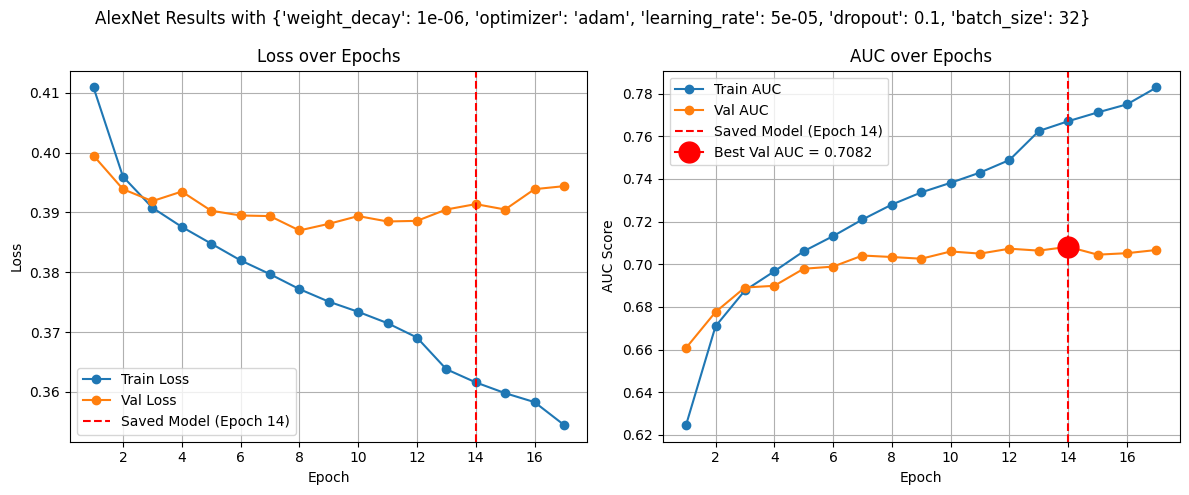

In [33]:
import matplotlib.pyplot as plt

# Epochs
epochs_alexnet = list(range(1, 18))
best_epoch_alexnet = 14
# Training and validation loss
train_loss_alexnet = [0.4109, 0.3960, 0.3908, 0.3876, 0.3848, 0.3820, 0.3797, 0.3772, 0.3751, 0.3734, 0.3715, 0.3691, 0.3638, 0.3616, 0.3598, 0.3583, 0.3545]
val_loss_alexnet   = [0.3995, 0.3939, 0.3919, 0.3935, 0.3903, 0.3895, 0.3894, 0.3870, 0.3881, 0.3894, 0.3885, 0.3886, 0.3905, 0.3914, 0.3905, 0.3939, 0.3944]

# Training and validation AUC
train_auc_alexnet = [0.6247, 0.6709, 0.6877, 0.6967, 0.7061, 0.7132, 0.7210, 0.7280, 0.7337, 0.7382, 0.7430, 0.7489, 0.7625, 0.7671, 0.7712, 0.7750, 0.7829]
val_auc_alexnet   = [0.6608, 0.6776, 0.6891, 0.6899, 0.6979, 0.6989, 0.7041, 0.7034, 0.7026, 0.7060, 0.7050, 0.7073, 0.7064, 0.7082, 0.7045, 0.7052, 0.7067]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.suptitle("AlexNet Results with {'weight_decay': 1e-06, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.1, 'batch_size': 32} ")
plt.subplot(1, 2, 1)
plt.plot(epochs_alexnet, train_loss_alexnet, label='Train Loss', marker='o')
plt.plot(epochs_alexnet, val_loss_alexnet, label='Val Loss', marker='o')
plt.axvline(x=best_epoch_alexnet, color='red', linestyle='--', label=f'Saved Model (Epoch {best_epoch_alexnet})')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_alexnet, train_auc_alexnet, label='Train AUC', marker='o')
plt.plot(epochs_alexnet, val_auc_alexnet, label='Val AUC', marker='o')
plt.axvline(x=best_epoch_alexnet, color='red', linestyle='--', label=f'Saved Model (Epoch {best_epoch_alexnet})')
plt.plot(best_epoch_alexnet, val_auc_alexnet[best_epoch_alexnet-1], marker='o', color='red', markersize=15, label=f'Best Val AUC = {val_auc_alexnet[best_epoch_alexnet-1]}')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
#{'weight_decay': 1e-06, 'optimizer': 'adam', 'learning_rate': 0.0001, 'dropout': 0.1, 'batch_size': 16}

import torch
import torch.nn as nn
import torchvision.models as models

densenet = models.densenet121(weights='IMAGENET1K_V1')

#for param in densenet.parameters():
  #  param.requires_grad = False

num_labels = 12
densenet.classifier = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(densenet.classifier.in_features, num_labels),
                nn.Sigmoid()
            )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet = densenet.to(device)

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(densenet.parameters(), lr=0.0001, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_loader_densenet = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader_densenet   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader_densenet  = DataLoader(test_dataset, batch_size=16, shuffle=False)

history_densenet ={'training_loss':[],
      'training_auc':[],
     'validation_loss': [],
     'validation_auc':[]}

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20):
    best_val_auc = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_outputs_list = []
        train_targets_list = []

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        loop = tqdm(train_loader, desc='Training', leave=False)

        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store outputs and targets for AUC calculation
            train_outputs_list.append(outputs.detach().cpu())
            train_targets_list.append(labels.detach().cpu())

            loop.set_postfix(loss=loss.item())

        # Calculate training AUC
        train_outputs_all = torch.cat(train_outputs_list, dim=0)
        train_targets_all = torch.cat(train_targets_list, dim=0)
        train_auc = calculate_auc(train_outputs_all, train_targets_all)

        avg_train_loss = train_loss / len(train_loader)
        print(f"Train Loss: {avg_train_loss:.4f} | AUC: {train_auc:.4f}")

        # Validate
        val_loss, val_auc = evaluate(model, val_loader, criterion, device)
        print(f"Val Loss:   {val_loss:.4f} | Val AUC: {val_auc:.4f}")

        history_alexnet['training_loss'].append(avg_train_loss)
        history_alexnet['validation_loss'].append(val_loss)        
        scheduler.step(val_loss)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), 'best_model_densenet.pth')
            print(f"New best model saved with AUC: {best_val_auc:.4f}")



train(densenet, train_loader_densenet, val_loader_densenet, criterion, optimizer, scheduler, device, epochs=20)
#Training time (DenseNet):59m 56s all epochs = 29 minutes
#Best Validation AUC score:0.7470


Epoch [1/20]


KeyboardInterrupt: 

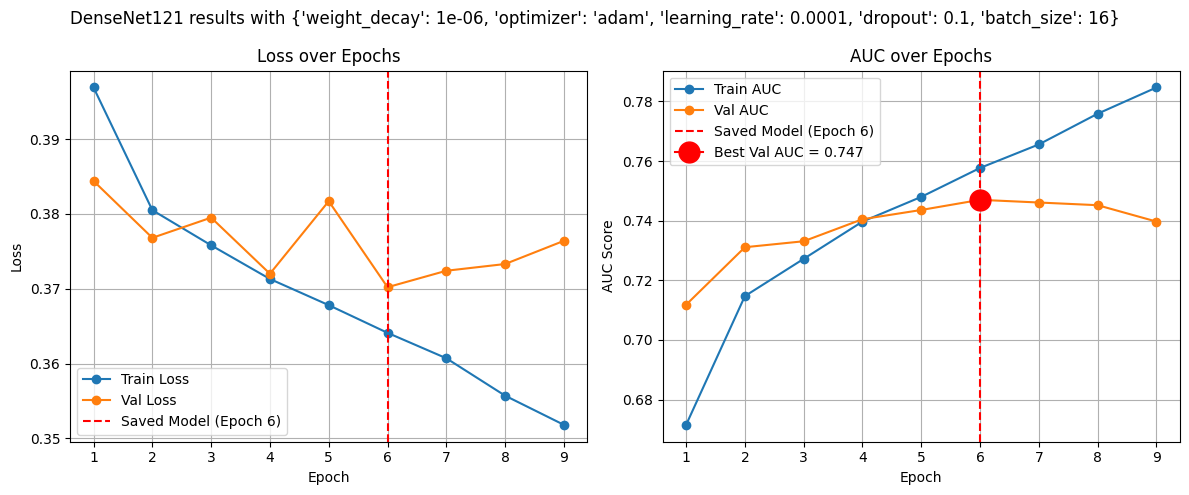

In [32]:
import matplotlib.pyplot as plt

# Epochs
epochs_densenet = list(range(1, 10))
best_epoch_densenet = 6
# Training and validation loss
train_loss_densenet = [0.3969, 0.3805, 0.3758, 0.3713, 0.3678, 0.3641, 0.3607, 0.3557, 0.3518]
val_loss_densenet   = [0.3844, 0.3768, 0.3795, 0.3720, 0.3817, 0.3702, 0.3724, 0.3733, 0.3764]

# Training and validation AUC
train_auc_densenet = [0.6715, 0.7147, 0.7272, 0.7397, 0.7480, 0.7577, 0.7656, 0.7759, 0.7847]
val_auc_densenet   = [0.7118, 0.7311, 0.7331, 0.7405, 0.7436, 0.7470, 0.7461, 0.7452, 0.7397]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.suptitle("DenseNet121 results with {'weight_decay': 1e-06, 'optimizer': 'adam', 'learning_rate': 0.0001, 'dropout': 0.1, 'batch_size': 16}")
plt.subplot(1, 2, 1)
plt.plot(epochs_densenet, train_loss_densenet, label='Train Loss', marker='o')
plt.plot(epochs_densenet, val_loss_densenet, label='Val Loss', marker='o')
plt.axvline(x=best_epoch_densenet, color='red', linestyle='--', label=f'Saved Model (Epoch {best_epoch_densenet})')

plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_densenet, train_auc_densenet, label='Train AUC', marker='o')
plt.plot(epochs_densenet, val_auc_densenet, label='Val AUC', marker='o')
plt.axvline(x=best_epoch_densenet, color='red', linestyle='--', label=f'Saved Model (Epoch {best_epoch_densenet})')
plt.plot(best_epoch_densenet, val_auc_densenet[best_epoch_densenet-1], marker='o', color='red', markersize=15, label=f'Best Val AUC = {val_auc_densenet[best_epoch_densenet-1]}')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
###{'weight_decay': 0.0001, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.1, 'batch_size': 48}



vit = models.vit_b_16(weights='IMAGENET1K_V1')

#for param in densenet.parameters():
  #  param.requires_grad = False

num_labels = 12
vit.heads = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(vit.heads.head.in_features, num_labels),
                nn.Sigmoid()
            )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit = vit.to(device)

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(vit.parameters(), lr=1e-5, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_loader_vit = DataLoader(train_dataset, batch_size=48, shuffle=True)
val_loader_vit   = DataLoader(val_dataset, batch_size=48, shuffle=False)
test_loader_vit  = DataLoader(test_dataset, batch_size=48, shuffle=False)

history_vit ={'training_loss':[],
      'training_auc':[],
     'validation_loss': [],
     'validation_auc':[]}

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20):
    best_val_auc = 0
    patience = 3
    patience_counter=0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_outputs_list = []
        train_targets_list = []

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        loop = tqdm(train_loader, desc='Training', leave=False)

        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store outputs and targets for AUC calculation
            train_outputs_list.append(outputs.detach().cpu())
            train_targets_list.append(labels.detach().cpu())

            loop.set_postfix(loss=loss.item())

        # Calculate training AUC
        train_outputs_all = torch.cat(train_outputs_list, dim=0)
        train_targets_all = torch.cat(train_targets_list, dim=0)
        train_auc = calculate_auc(train_outputs_all, train_targets_all)

        avg_train_loss = train_loss / len(train_loader)
        print(f"Train Loss: {avg_train_loss:.4f} | AUC: {train_auc:.4f}")

        # Validate
        val_loss, val_auc = evaluate(model, val_loader, criterion, device)
        print(f"Val Loss:   {val_loss:.4f} | Val AUC: {val_auc:.4f}")

        history_vit['training_loss'].append(avg_train_loss)
        history_vit['training_auc'].append(train_auc)
        history_vit['validation_loss'].append(val_loss)
        history_vit['validation_auc'].append(val_auc)        
        scheduler.step(val_loss)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), 'best_model_vit.pth')
            print(f"New best model saved with AUC: {best_val_auc:.4f}")
            patience_counter=0
        else:
            patience_counter+=1
            if patience_counter>=patience:
                print(f"Early stopping at epoch {epoch+1}")
                break



train(vit, train_loader_vit, val_loader_vit, criterion, optimizer, scheduler, device, epochs=20)


#Training time:48 min
# Best Validation AUC score:0.7377


Epoch [1/20]


KeyboardInterrupt: 

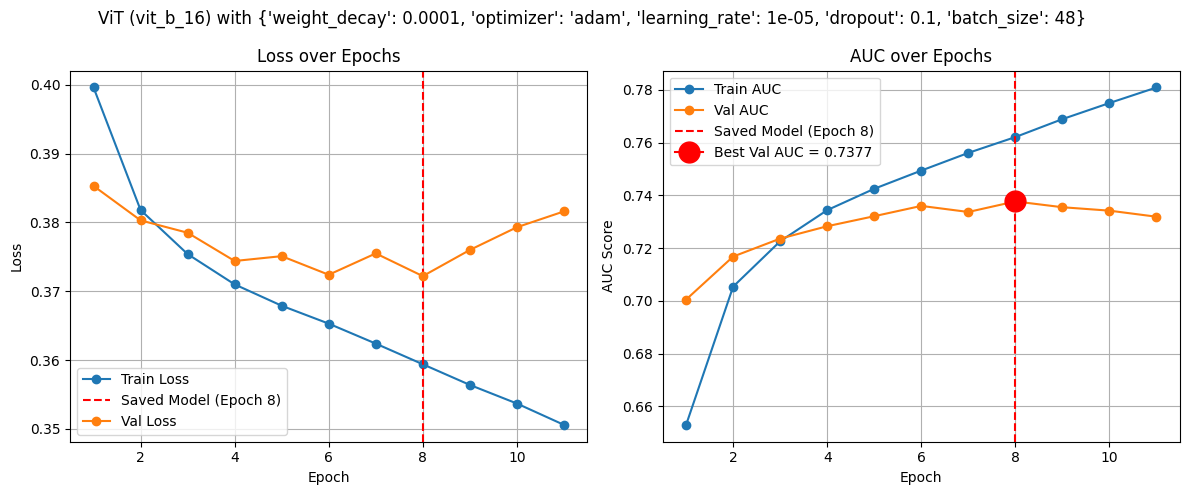

In [30]:
import matplotlib.pyplot as plt

# Epochs
epochs_vit = list(range(1, 12))
best_epoch_vit = 8

# Training and validation loss
train_loss_vit = [0.3996, 0.3818, 0.3754, 0.3710, 0.3679, 0.3653, 0.3624, 0.3594, 0.3564, 0.3537, 0.3506]
val_loss_vit   = [0.3853, 0.3803, 0.3785, 0.3744, 0.3751, 0.3724, 0.3755, 0.3722, 0.3760, 0.3793, 0.3816]

# Training and validation AUC
train_auc_vit = [0.6530, 0.7054, 0.7226, 0.7344, 0.7425, 0.7494, 0.7561, 0.7621, 0.7689, 0.7750, 0.7809]
val_auc_vit   = [0.7005, 0.7168, 0.7236, 0.7283, 0.7321, 0.7360, 0.7337, 0.7377, 0.7355, 0.7342, 0.7319]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.suptitle("ViT (vit_b_16) with {'weight_decay': 0.0001, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.1, 'batch_size': 48} ")
plt.subplot(1, 2, 1)
plt.plot(epochs_vit, train_loss_vit, label='Train Loss', marker='o')
plt.axvline(x=best_epoch_vit, color='red', linestyle='--', label=f'Saved Model (Epoch {best_epoch_vit})')
plt.plot(epochs_vit, val_loss_vit, label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_vit, train_auc_vit, label='Train AUC', marker='o')
plt.plot(epochs_vit, val_auc_vit, label='Val AUC', marker='o')
plt.axvline(x=best_epoch_vit, color='red', linestyle='--', label=f'Saved Model (Epoch {best_epoch_vit})')
plt.plot(best_epoch_vit, val_auc_vit[best_epoch_vit-1], marker='o', color='red', markersize=15, label=f'Best Val AUC = {val_auc_vit[best_epoch_vit-1]}')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
#{'weight_decay': 0.0, 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'dropout': 0.2, 'batch_size': 64}



resnet = models.resnet101(weights='IMAGENET1K_V1')

#for param in densenet.parameters():
  #  param.requires_grad = False

num_labels = 12
resnet.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(resnet.fc.in_features, num_labels),
                nn.Sigmoid()
            )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

criterion = nn.BCELoss()

optimizer = torch.optim.RMSprop(resnet.parameters(), lr=0.0001, weight_decay=0)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_loader_resnet = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_resnet   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_resnet  = DataLoader(test_dataset, batch_size=64, shuffle=False)

history_resnet ={'training_loss':[],
      'training_auc':[],
     'validation_loss': [],
     'validation_auc':[]}

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20):
    best_val_auc = 0
    patience = 3
    patience_counter=0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_outputs_list = []
        train_targets_list = []

        print(f"\nEpoch [{epoch+1}/{epochs}]")
        loop = tqdm(train_loader, desc='Training', leave=False)

        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Store outputs and targets for AUC calculation
            train_outputs_list.append(outputs.detach().cpu())
            train_targets_list.append(labels.detach().cpu())

            loop.set_postfix(loss=loss.item())

        # Calculate training AUC
        train_outputs_all = torch.cat(train_outputs_list, dim=0)
        train_targets_all = torch.cat(train_targets_list, dim=0)
        train_auc = calculate_auc(train_outputs_all, train_targets_all)

        avg_train_loss = train_loss / len(train_loader)
        print(f"Train Loss: {avg_train_loss:.4f} | AUC: {train_auc:.4f}")

        # Validate
        val_loss, val_auc = evaluate(model, val_loader, criterion, device)
        print(f"Val Loss:   {val_loss:.4f} | Val AUC: {val_auc:.4f}")

        history_resnet['training_loss'].append(avg_train_loss)
        history_resnet['training_auc'].append(train_auc)
        history_resnet['validation_loss'].append(val_loss)
        history_resnet['validation_auc'].append(val_auc)        
        scheduler.step(val_loss)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), 'best_model_resnet.pth')
            print(f"New best model saved with AUC: {best_val_auc:.4f}")
            patience_counter=0
        else:
            patience_counter+=1
            if patience_counter>patience:
                print(f"Early stopping at epoch {epoch+1}")
                break



train(resnet, train_loader_resnet, val_loader_resnet, criterion, optimizer, scheduler, device, epochs=20)

#Time taken: 43 minutes


Epoch [1/20]


KeyboardInterrupt: 

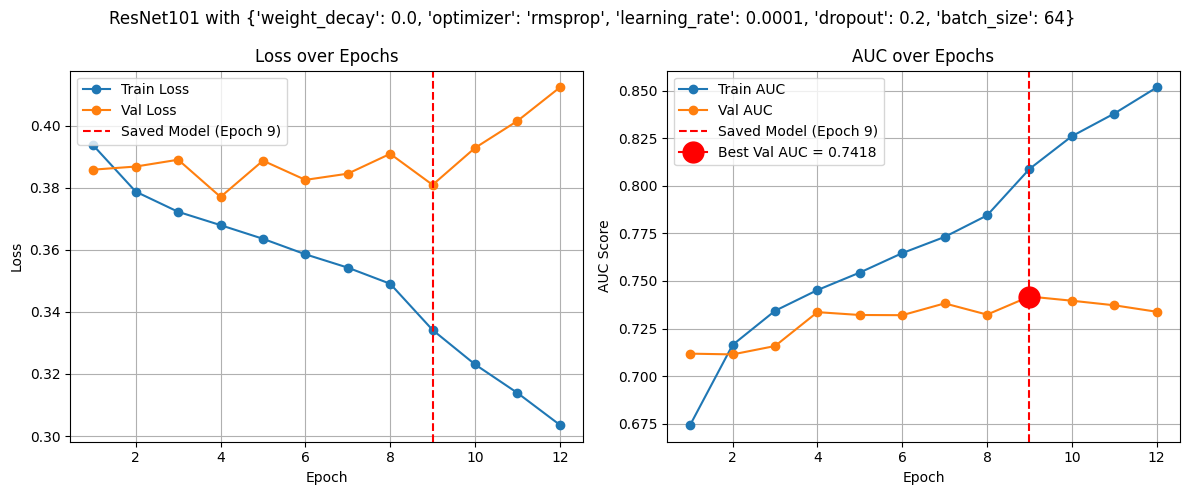

In [34]:
import matplotlib.pyplot as plt

# Epochs
epochs_resnet = list(range(1, 13))
best_epoch_resnet = 9

# Training and validation loss
train_loss_resnet = [0.3937, 0.3788, 0.3723, 0.3680, 0.3636, 0.3586, 0.3543, 0.3491, 0.3342, 0.3231, 0.3139, 0.3036]
val_loss_resnet   = [0.3859, 0.3869, 0.3891, 0.3771, 0.3888, 0.3826, 0.3846, 0.3910, 0.3810, 0.3929, 0.4016, 0.4124]

# Training and validation AUC
train_auc_resnet = [0.6744, 0.7164, 0.7343, 0.7452, 0.7544, 0.7646, 0.7731, 0.7844, 0.8088, 0.8260, 0.8379, 0.8516]
val_auc_resnet  = [0.7118, 0.7114, 0.7158, 0.7336, 0.7321, 0.7320, 0.7382, 0.7323, 0.7418, 0.7396, 0.7372, 0.7338]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.suptitle("ResNet101 with {'weight_decay': 0.0, 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'dropout': 0.2, 'batch_size': 64} ")
plt.subplot(1, 2, 1)
plt.plot(epochs_resnet, train_loss_resnet, label='Train Loss', marker='o')
plt.plot(epochs_resnet, val_loss_resnet, label='Val Loss', marker='o')
plt.axvline(x=best_epoch_resnet, color='red', linestyle='--', label=f'Saved Model (Epoch {best_epoch_resnet})')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_resnet, train_auc_resnet, label='Train AUC', marker='o')
plt.plot(epochs_resnet, val_auc_resnet, label='Val AUC', marker='o')
plt.axvline(x=best_epoch_resnet, color='red', linestyle='--', label=f'Saved Model (Epoch {best_epoch_resnet})')
plt.plot(best_epoch_resnet, val_auc_resnet[best_epoch_resnet - 1], marker='o', color='red', markersize=15, label=f'Best Val AUC = {val_auc_resnet[best_epoch_resnet-1]}')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Testing AlexNet

In [48]:
from sklearn.metrics import accuracy_score

def test_model_alexnet(model_path, test_loader, device):
    model = models.alexnet(weights=None)
    model.classifier = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(model.classifier[1].in_features, num_labels),
                nn.Sigmoid()
            )  
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # Concatenate all batches
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate AUC for each label
    auc_scores = []
    label_names = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
        'Lung Opacity', 'No Finding', 'Pleural Effusion',
        'Pneumonia', 'Pneumothorax'
    ]

    print("\nPer-label AUC scores:")
    for i, label_name in enumerate(label_names):
        try:
            if len(np.unique(all_targets[:, i])) > 1:  # Check if both classes are present
                auc = roc_auc_score(all_targets[:, i], all_outputs[:, i])
                auc_scores.append(auc)
                print(f"{label_name}: {auc:.4f}")
            else:
                print(f"{label_name}: Cannot calculate AUC (only one class present)")
        except ValueError:
            print(f"{label_name}: Error calculating AUC")

    # Calculate mean AUC
    mean_auc = np.mean(auc_scores) if auc_scores else 0.0
    print(f"\nMean AUC: {mean_auc:.4f}")

    # Calculate accuracy using threshold
    predictions = (all_outputs >= 0.5).astype(int)

    # Calculate per-label accuracy
    print("\nPer-label Accuracy:")
    for i, label_name in enumerate(label_names):
        acc = accuracy_score(all_targets[:, i], predictions[:, i])
        print(f"{label_name}: {acc:.4f}")

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_targets.flatten(), predictions.flatten())
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    return {
        'mean_auc': mean_auc,
        'overall_accuracy': overall_accuracy,
        'per_label_auc': dict(zip(label_names, auc_scores)),
        'per_label_accuracy': {label_names[i]: accuracy_score(all_targets[:, i], predictions[:, i])
                              for i in range(len(label_names))},
        'predictions': predictions,
        'probabilities': all_outputs,
        'targets': all_targets
    }

test_model_alexnet("best_model_alexnet.pth", test_loader, device)

Model loaded from best_model_alexnet.pth


Testing: 100%|██████████| 139/139 [00:12<00:00, 10.76it/s]


Per-label AUC scores:
Atelectasis: 0.7109
Cardiomegaly: 0.7006
Consolidation: 0.6899
Edema: 0.8017
Enlarged Cardiomediastinum: 0.5863
Fracture: 0.6088
Lung Lesion: 0.6672
Lung Opacity: 0.6650
No Finding: 0.7780
Pleural Effusion: 0.8184
Pneumonia: 0.6598
Pneumothorax: 0.7727

Mean AUC: 0.7049

Per-label Accuracy:
Atelectasis: 0.6707
Cardiomegaly: 0.6956
Consolidation: 0.9054
Edema: 0.7837
Enlarged Cardiomediastinum: 0.8912
Fracture: 0.9805
Lung Lesion: 0.9692
Lung Opacity: 0.6845
No Finding: 0.8310
Pleural Effusion: 0.7470
Pneumonia: 0.8273
Pneumothorax: 0.9348

Overall Accuracy: 0.8268


{'mean_auc': 0.7049309962296838,
 'overall_accuracy': 0.8267519046541449,
 'per_label_auc': {'Atelectasis': 0.7108955314104302,
  'Cardiomegaly': 0.7006076951645389,
  'Consolidation': 0.6899034282380119,
  'Edema': 0.8017082867766687,
  'Enlarged Cardiomediastinum': 0.5862828097464968,
  'Fracture': 0.6088133792044826,
  'Lung Lesion': 0.6671667691611709,
  'Lung Opacity': 0.6649713795458394,
  'No Finding': 0.7779517822602929,
  'Pleural Effusion': 0.8184367475814475,
  'Pneumonia': 0.6597527392254487,
  'Pneumothorax': 0.7726814064413765},
 'per_label_accuracy': {'Atelectasis': 0.6707399864222675,
  'Cardiomegaly': 0.695632496039828,
  'Consolidation': 0.90540846345327,
  'Edema': 0.7836614618692012,
  'Enlarged Cardiomediastinum': 0.8911518443086671,
  'Fracture': 0.9805385833899072,
  'Lung Lesion': 0.9692238062910161,
  'Lung Opacity': 0.6845440144829147,
  'No Finding': 0.8309572301425662,
  'Pleural Effusion': 0.7470015840687938,
  'Pneumonia': 0.827336501470921,
  'Pneumothora

# DenseNet

In [49]:
from sklearn.metrics import accuracy_score

def test_model_densenet(model_path, test_loader, device):
    model = models.densenet121(weights=None)
    model.classifier = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(model.classifier.in_features, num_labels),
                nn.Sigmoid()
            )  
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # Concatenate all batches
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate AUC for each label
    auc_scores = []
    label_names = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
        'Lung Opacity', 'No Finding', 'Pleural Effusion',
        'Pneumonia', 'Pneumothorax'
    ]

    print("\nPer-label AUC scores:")
    for i, label_name in enumerate(label_names):
        try:
            if len(np.unique(all_targets[:, i])) > 1:  # Check if both classes are present
                auc = roc_auc_score(all_targets[:, i], all_outputs[:, i])
                auc_scores.append(auc)
                print(f"{label_name}: {auc:.4f}")
            else:
                print(f"{label_name}: Cannot calculate AUC (only one class present)")
        except ValueError:
            print(f"{label_name}: Error calculating AUC")

    # Calculate mean AUC
    mean_auc = np.mean(auc_scores) if auc_scores else 0.0
    print(f"\nMean AUC: {mean_auc:.4f}")

    # Calculate accuracy using threshold
    predictions = (all_outputs >= 0.5).astype(int)

    # Calculate per-label accuracy
    print("\nPer-label Accuracy:")
    for i, label_name in enumerate(label_names):
        acc = accuracy_score(all_targets[:, i], predictions[:, i])
        print(f"{label_name}: {acc:.4f}")

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_targets.flatten(), predictions.flatten())
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    return {
        'mean_auc': mean_auc,
        'overall_accuracy': overall_accuracy,
        'per_label_auc': dict(zip(label_names, auc_scores)),
        'per_label_accuracy': {label_names[i]: accuracy_score(all_targets[:, i], predictions[:, i])
                              for i in range(len(label_names))},
        'predictions': predictions,
        'probabilities': all_outputs,
        'targets': all_targets
    }

test_model_densenet("best_model_densenet.pth", test_loader_densenet, device)

Model loaded from best_model_densenet.pth


Testing: 100%|██████████| 277/277 [00:15<00:00, 17.70it/s]


Per-label AUC scores:
Atelectasis: 0.7285
Cardiomegaly: 0.7179
Consolidation: 0.7244
Edema: 0.8185
Enlarged Cardiomediastinum: 0.6130
Fracture: 0.6694
Lung Lesion: 0.7155
Lung Opacity: 0.6953
No Finding: 0.7891
Pleural Effusion: 0.8454
Pneumonia: 0.7085
Pneumothorax: 0.8370

Mean AUC: 0.7385

Per-label Accuracy:
Atelectasis: 0.6818
Cardiomegaly: 0.7047
Consolidation: 0.9047
Edema: 0.7920
Enlarged Cardiomediastinum: 0.8914
Fracture: 0.9805
Lung Lesion: 0.9697
Lung Opacity: 0.6929
No Finding: 0.8513
Pleural Effusion: 0.7721
Pneumonia: 0.8280
Pneumothorax: 0.9409

Overall Accuracy: 0.8342


{'mean_auc': 0.7385326376939899,
 'overall_accuracy': 0.8341819416157502,
 'per_label_auc': {'Atelectasis': 0.728506484928949,
  'Cardiomegaly': 0.7179234057122972,
  'Consolidation': 0.7243822860477023,
  'Edema': 0.8185006674965032,
  'Enlarged Cardiomediastinum': 0.6129545375355431,
  'Fracture': 0.6693627595682673,
  'Lung Lesion': 0.7154982293190831,
  'Lung Opacity': 0.6953445868439125,
  'No Finding': 0.789097471677259,
  'Pleural Effusion': 0.8453723214391037,
  'Pneumonia': 0.708457455519827,
  'Pneumothorax': 0.8369914462394322},
 'per_label_accuracy': {'Atelectasis': 0.6818284679791808,
  'Cardiomegaly': 0.7046843177189409,
  'Consolidation': 0.9047295768273365,
  'Edema': 0.7920343969223806,
  'Enlarged Cardiomediastinum': 0.891378139850645,
  'Fracture': 0.9805385833899072,
  'Lung Lesion': 0.9696763973749717,
  'Lung Opacity': 0.6929169495360942,
  'No Finding': 0.8513238289205702,
  'Pleural Effusion': 0.7721203892283321,
  'Pneumonia': 0.8280153880968545,
  'Pneumothora

# VisionTransformer

In [50]:

def test_model_vit(model_path, test_loader, device):
    model = models.vit_b_16(weights=None)
    model.heads = nn.Sequential(
                nn.Dropout(0.1),
                nn.Linear(model.heads.head.in_features, num_labels),
                nn.Sigmoid()
            )  
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # Concatenate all batches
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate AUC for each label
    auc_scores = []
    label_names = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
        'Lung Opacity', 'No Finding', 'Pleural Effusion',
        'Pneumonia', 'Pneumothorax'
    ]

    print("\nPer-label AUC scores:")
    for i, label_name in enumerate(label_names):
        try:
            if len(np.unique(all_targets[:, i])) > 1:  # Check if both classes are present
                auc = roc_auc_score(all_targets[:, i], all_outputs[:, i])
                auc_scores.append(auc)
                print(f"{label_name}: {auc:.4f}")
            else:
                print(f"{label_name}: Cannot calculate AUC (only one class present)")
        except ValueError:
            print(f"{label_name}: Error calculating AUC")

    # Calculate mean AUC
    mean_auc = np.mean(auc_scores) if auc_scores else 0.0
    print(f"\nMean AUC: {mean_auc:.4f}")

    # Calculate accuracy using threshold
    predictions = (all_outputs >= 0.5).astype(int)

    # Calculate per-label accuracy
    print("\nPer-label Accuracy:")
    for i, label_name in enumerate(label_names):
        acc = accuracy_score(all_targets[:, i], predictions[:, i])
        print(f"{label_name}: {acc:.4f}")

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_targets.flatten(), predictions.flatten())
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    return {
        'mean_auc': mean_auc,
        'overall_accuracy': overall_accuracy,
        'per_label_auc': dict(zip(label_names, auc_scores)),
        'per_label_accuracy': {label_names[i]: accuracy_score(all_targets[:, i], predictions[:, i])
                              for i in range(len(label_names))},
        'predictions': predictions,
        'probabilities': all_outputs,
        'targets': all_targets
    }

test_model_vit("best_model_vit.pth", test_loader_vit, device)

Model loaded from best_model_vit.pth


Testing: 100%|██████████| 93/93 [00:16<00:00,  5.74it/s]


Per-label AUC scores:
Atelectasis: 0.7300
Cardiomegaly: 0.7238
Consolidation: 0.7332
Edema: 0.8152
Enlarged Cardiomediastinum: 0.6097
Fracture: 0.5850
Lung Lesion: 0.6898
Lung Opacity: 0.6927
No Finding: 0.7960
Pleural Effusion: 0.8422
Pneumonia: 0.7012
Pneumothorax: 0.8207

Mean AUC: 0.7283

Per-label Accuracy:
Atelectasis: 0.6832
Cardiomegaly: 0.7099
Consolidation: 0.9052
Edema: 0.7862
Enlarged Cardiomediastinum: 0.8912
Fracture: 0.9805
Lung Lesion: 0.9701
Lung Opacity: 0.6952
No Finding: 0.8362
Pleural Effusion: 0.7687
Pneumonia: 0.8226
Pneumothorax: 0.9391

Overall Accuracy: 0.8323


{'mean_auc': 0.7282909936276716,
 'overall_accuracy': 0.8323338613562646,
 'per_label_auc': {'Atelectasis': 0.730022097789997,
  'Cardiomegaly': 0.723791508919442,
  'Consolidation': 0.7332029435930411,
  'Edema': 0.8151913180335526,
  'Enlarged Cardiomediastinum': 0.6096992996434337,
  'Fracture': 0.5849940156398434,
  'Lung Lesion': 0.6898162874370013,
  'Lung Opacity': 0.6926877545546375,
  'No Finding': 0.7959577922077921,
  'Pleural Effusion': 0.8422104978485008,
  'Pneumonia': 0.7012204316241567,
  'Pneumothorax': 0.8206979762406603},
 'per_label_accuracy': {'Atelectasis': 0.6831862412310478,
  'Cardiomegaly': 0.7098891151844309,
  'Consolidation': 0.9051821679112921,
  'Edema': 0.7861507128309573,
  'Enlarged Cardiomediastinum': 0.8911518443086671,
  'Fracture': 0.9805385833899072,
  'Lung Lesion': 0.9701289884589274,
  'Lung Opacity': 0.6951799049558723,
  'No Finding': 0.8361620276080561,
  'Pleural Effusion': 0.7687259560986649,
  'Pneumonia': 0.8225842950893867,
  'Pneumotho

# ResNet101

In [51]:

def test_model_resnet(model_path, test_loader, device):
    model = models.resnet101(weights=None)
    model.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(model.fc.in_features, num_labels),
                nn.Sigmoid()
            )  
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # Concatenate all batches
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate AUC for each label
    auc_scores = []
    label_names = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
        'Lung Opacity', 'No Finding', 'Pleural Effusion',
        'Pneumonia', 'Pneumothorax'
    ]

    print("\nPer-label AUC scores:")
    for i, label_name in enumerate(label_names):
        try:
            if len(np.unique(all_targets[:, i])) > 1:  # Check if both classes are present
                auc = roc_auc_score(all_targets[:, i], all_outputs[:, i])
                auc_scores.append(auc)
                print(f"{label_name}: {auc:.4f}")
            else:
                print(f"{label_name}: Cannot calculate AUC (only one class present)")
        except ValueError:
            print(f"{label_name}: Error calculating AUC")

    # Calculate mean AUC
    mean_auc = np.mean(auc_scores) if auc_scores else 0.0
    print(f"\nMean AUC: {mean_auc:.4f}")

    # Calculate accuracy using threshold
    predictions = (all_outputs >= 0.5).astype(int)

    # Calculate per-label accuracy
    print("\nPer-label Accuracy:")
    for i, label_name in enumerate(label_names):
        acc = accuracy_score(all_targets[:, i], predictions[:, i])
        print(f"{label_name}: {acc:.4f}")

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_targets.flatten(), predictions.flatten())
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
    return {
        'mean_auc': mean_auc,
        'overall_accuracy': overall_accuracy,
        'per_label_auc': dict(zip(label_names, auc_scores)),
        'per_label_accuracy': {label_names[i]: accuracy_score(all_targets[:, i], predictions[:, i])
                              for i in range(len(label_names))},
        'predictions': predictions,
        'probabilities': all_outputs,
        'targets': all_targets
    }

test_model_resnet("best_model_resnet.pth", test_loader_resnet, device)

Model loaded from best_model_resnet.pth


Testing: 100%|██████████| 70/70 [00:15<00:00,  4.60it/s]


Per-label AUC scores:
Atelectasis: 0.7210
Cardiomegaly: 0.7078
Consolidation: 0.7333
Edema: 0.8151
Enlarged Cardiomediastinum: 0.6112
Fracture: 0.6478
Lung Lesion: 0.7193
Lung Opacity: 0.6945
No Finding: 0.7851
Pleural Effusion: 0.8446
Pneumonia: 0.7063
Pneumothorax: 0.8310

Mean AUC: 0.7348

Per-label Accuracy:
Atelectasis: 0.6707
Cardiomegaly: 0.7067
Consolidation: 0.9041
Edema: 0.7868
Enlarged Cardiomediastinum: 0.8900
Fracture: 0.9805
Lung Lesion: 0.9642
Lung Opacity: 0.6886
No Finding: 0.8439
Pleural Effusion: 0.7708
Pneumonia: 0.8258
Pneumothorax: 0.9394

Overall Accuracy: 0.8310


{'mean_auc': 0.7347580647096441,
 'overall_accuracy': 0.8309572301425662,
 'per_label_auc': {'Atelectasis': 0.7210298420914764,
  'Cardiomegaly': 0.7077578892322143,
  'Consolidation': 0.7333142809511901,
  'Edema': 0.8151228432431573,
  'Enlarged Cardiomediastinum': 0.6112450888987202,
  'Fracture': 0.6477895437395005,
  'Lung Lesion': 0.7193276360526186,
  'Lung Opacity': 0.6944630977813203,
  'No Finding': 0.7851378143133463,
  'Pleural Effusion': 0.8446184556652216,
  'Pneumonia': 0.7062656422813616,
  'Pneumothorax': 0.8310246422656015},
 'per_label_accuracy': {'Atelectasis': 0.6707399864222675,
  'Cardiomegaly': 0.7067209775967414,
  'Consolidation': 0.904050690201403,
  'Edema': 0.7868295994568907,
  'Enlarged Cardiomediastinum': 0.890020366598778,
  'Fracture': 0.9805385833899072,
  'Lung Lesion': 0.964245304367504,
  'Lung Opacity': 0.6886173342385155,
  'No Finding': 0.8438560760353021,
  'Pleural Effusion': 0.7707626159764652,
  'Pneumonia': 0.8257524326770762,
  'Pneumothor